(page-parameter-learning)=

# Parameter learning in Spiking Neural Networks
Author: Christian Pehle

As we have already seen in {ref}`page-spiking` Neuron models come with parameters, such as membrane time constants, which determine their dynamics. While those parameters are often treated as arbitrarily treated constants and therefore *hyperparameters* in a machine learning context, more recently it has become clear that it can be benefitial to treat them as *parameters*. In this notebook, we will first learn how to initialise a network of LIF neurons with distinct, but fixed time constants and voltage thresholds and then how to incorporate them into the optimisation. As we will see, this is largely facilitated by the pre-existing ways of treating parameters in PyTorch.

In [11]:
import torch
import norse
import matplotlib.pyplot as plt

## Defining a Network of LIF Neurons with varying membrane time-constants

A population of recurrently connected LIF neurons can be instantiated in Norse as follows:

In [58]:
from norse.torch.module import LIFRecurrentCell

m = LIFRecurrentCell(input_size=200, hidden_size=100)
m

LIFRecurrentCell(input_size=200, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.)), autapses=False, dt=0.001)

As you can see the `LIFParameters` are initialised to some default values. It is easy enough to instead sample these values from a given distribution. While we will use a random normal distribution here, a more appropriate choice would be for example a lognormal distribution, as this would guarantee that the inverse membrane time constant remains positive, which is an essential requirement. Here we just choose the standard deviation in such a way, that a negative value would be very unlikely.

Text(0.5, 0, '$\\tau_{m}^{-1}$ [ms]')

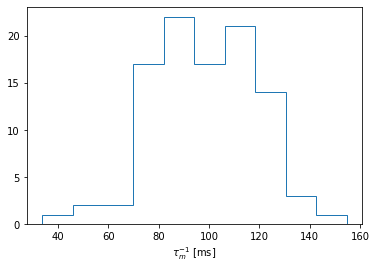

In [236]:
import numpy as np

counts, bins = np.histogram(norse.torch.functional.lif.LIFParameters().tau_mem_inv + 20*torch.randn(100))
plt.hist(bins[:-1], bins, weights=counts, histtype='step')
plt.xlabel('$\\tau_{m}^{-1}$ [ms]')

The parameters of a PyTorch module can be accesses by invoking the `parameters` method. In the case of the `LIFRecurrentCell` those are the recurrent and input weight matrices. Note how both tensors have `requires_grad=True` and that the `LIFParameters` do not appear. This is because none of the tensors entering the `LIFParameters` have been registered as a PyTorch Parameter.

In [60]:
list(m.parameters())

[Parameter containing:
 tensor([[ 0.1287, -0.0703, -0.4601,  ..., -0.0114, -0.0835,  0.1185],
         [ 0.0429,  0.0861,  0.2161,  ..., -0.3251, -0.1037, -0.0786],
         [-0.3725, -0.0945,  0.1543,  ...,  0.1508, -0.0733,  0.2225],
         ...,
         [-0.0465, -0.2300, -0.0681,  ..., -0.2809, -0.1205,  0.0732],
         [-0.3285, -0.0445,  0.1016,  ..., -0.1084, -0.0621,  0.2362],
         [-0.0088,  0.0473, -0.2168,  ...,  0.0307,  0.2217,  0.0065]],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.0000,  0.0420,  0.1593,  ..., -0.0059,  0.2016, -0.2879],
         [-0.0932,  0.0000, -0.0390,  ...,  0.2117, -0.0844, -0.0938],
         [-0.0210, -0.1170,  0.0000,  ...,  0.0709, -0.2757,  0.0067],
         ...,
         [-0.1806, -0.0191,  0.2278,  ...,  0.0000, -0.1108,  0.0404],
         [-0.0023,  0.0122, -0.0125,  ...,  0.1097,  0.0000, -0.1081],
         [ 0.0801,  0.0539, -0.0436,  ..., -0.1712, -0.2872,  0.0000]],
        requires_grad=True)]

The easiest way to rectify this situation is to define an additional `torch.nn.Module` and explicitely register the inverse membrane time constant and threshold as a parameter.

In [225]:
class ParametrizedLIFRecurrentCell(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ParametrizedLIFRecurrentCell, self).__init__()
        self.tau_mem_inv = torch.nn.Parameter(norse.torch.functional.lif.LIFParameters().tau_mem_inv + 20*torch.randn(hidden_size))
        self.v_th = torch.nn.Parameter(0.5 + 0.1 * torch.randn(hidden_size))
        self.cell = norse.torch.module.LIFRecurrentCell(input_size=input_size, hidden_size=hidden_size, 
                                                        p = norse.torch.functional.lif.LIFParameters(
                                                            tau_mem_inv = self.tau_mem_inv,
                                                            v_th = self.v_th,
                                                            alpha = 100,
                                                        )
                                                        
        )

    def forward(self, x, s = None):
        return self.cell(x, s)

In [226]:
m = ParametrizedLIFRecurrentCell(200, 100)
m

ParametrizedLIFRecurrentCell(
  (cell): LIFRecurrentCell(
    input_size=200, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=Parameter containing:
    tensor([105.7182, 107.4838, 100.0283, 105.1591,  53.3966, 109.9805,  96.5298,
             98.7639,  61.6523, 100.5165, 123.9547,  91.8613,  74.4375,  77.2754,
             70.4332,  75.0951,  74.7826, 128.1384,  62.5254,  98.4896, 132.6102,
            101.3723,  94.8174, 113.6608,  92.8799, 102.4582,  96.0418, 109.7185,
             97.0302,  94.2958, 106.0022, 111.0281,  57.8042,  60.2294, 124.0950,
            120.5536,  85.0079, 122.0159, 102.3311,  82.8800,  91.6850, 109.0127,
             81.5401, 140.7032, 102.0714,  92.9130,  81.3563, 131.6322,  88.3253,
             80.4107,  90.0314, 111.8495,  78.5712,  61.6052,  91.2183, 142.2331,
            100.1681,  97.8471,  90.6644, 115.2660,  89.4297,  85.5509,  27.3883,
             44.9216,  82.8977, 130.8837, 115.9058, 110.5285,  65.6668, 100.6617,
         

The inverse membrane time constant and the threshold value now also appears as parameters:

In [227]:
list(m.parameters())

[Parameter containing:
 tensor([105.7182, 107.4838, 100.0283, 105.1591,  53.3966, 109.9805,  96.5298,
          98.7639,  61.6523, 100.5165, 123.9547,  91.8613,  74.4375,  77.2754,
          70.4332,  75.0951,  74.7826, 128.1384,  62.5254,  98.4896, 132.6102,
         101.3723,  94.8174, 113.6608,  92.8799, 102.4582,  96.0418, 109.7185,
          97.0302,  94.2958, 106.0022, 111.0281,  57.8042,  60.2294, 124.0950,
         120.5536,  85.0079, 122.0159, 102.3311,  82.8800,  91.6850, 109.0127,
          81.5401, 140.7032, 102.0714,  92.9130,  81.3563, 131.6322,  88.3253,
          80.4107,  90.0314, 111.8495,  78.5712,  61.6052,  91.2183, 142.2331,
         100.1681,  97.8471,  90.6644, 115.2660,  89.4297,  85.5509,  27.3883,
          44.9216,  82.8977, 130.8837, 115.9058, 110.5285,  65.6668, 100.6617,
          99.4103, 114.3868,  87.7616,  92.7753, 120.3395,  90.8698,  96.0968,
          94.1020, 134.0003,  92.5420, 119.3351, 108.7738, 106.1515, 100.8721,
          69.7877, 114.0343, 

## Toy Example: Training a small recurrent SNN on MNIST

In order to demonstrate training on an example task, we turn to MNIST. The training and testing code here is adopted from  the training notebook on MNIST and serves as an illustration. We do not necessarily expect there to be a great benefit in optimising the time-constants and threshold in this example.

### Dataset Loading

In [64]:
import torchvision

BATCH_SIZE = 256

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_data = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE
)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



### Model Defitinition

For simplicity we are considering a simple network with a single hidden layer of recurrently connected neurons.

In [152]:
from norse.torch import LICell

class SNN(torch.nn.Module):
    def __init__(self, 
                 input_features,
                 hidden_features, 
                 output_features,
                 recurrent_cell
                ):
        super(SNN, self).__init__()
        self.cell = recurrent_cell
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell()
        self.input_features = input_features
                             
    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []


        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.cell(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            voltages += [vo]
        
        return torch.stack(voltages)

In [154]:
class Model(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

### Training and Test loop

Both the training and test loop are independent of the model or dataset that we are using, in practice you should however probably use a more sophisticated version as they don't take care of parameter checkpoints or other concerns.

In [155]:
from tqdm.notebook import tqdm, trange

def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

In [156]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [201]:
from norse.torch import ConstantCurrentLIFEncoder

def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y


T = 32
LR = 0.002
INPUT_FEATURES = 28*28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10
EPOCHS = 5

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

In [202]:
def run_training(model, optimizer, epochs = EPOCHS):
    training_losses = []
    mean_losses = []
    test_losses = []
    accuracies = []

    torch.autograd.set_detect_anomaly(True)

    for epoch in trange(epochs):
        training_loss, mean_loss = train(model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS)
        test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
        training_losses += training_loss
        mean_losses.append(mean_loss)
        test_losses.append(test_loss)
        accuracies.append(accuracy)

    print(f"final accuracy: {accuracies[-1]}")
    return model

### Model Evaluation

With all of this boilerplate out of the way we can define our final model and run training for a number of epochs (10 by default). If you are impatient you can decrease that number to 1-2. With the default values, the result will be a test accuracy of >95%, that is nothing to write home about. 

In [235]:
model = Model(
    encoder=ConstantCurrentLIFEncoder(
      seq_length=T,
    ),
    snn=SNN(
      input_features=INPUT_FEATURES,
      hidden_features=HIDDEN_FEATURES,
      output_features=OUTPUT_FEATURES,
      recurrent_cell=ParametrizedLIFRecurrentCell(
            input_size=28*28, 
            hidden_size=100
      )
    ),
    decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [229]:
tau_mem_inv_before = model.snn.cell.cell.p.tau_mem_inv.cpu().detach().numpy()
v_th_before = model.snn.cell.cell.p.v_th.cpu().detach().numpy()

In [230]:
model_after = run_training(model, optimizer, epochs=10)


final accuracy: 95.94


In [231]:
tau_mem_inv_after = model_after.snn.cell.cell.p.tau_mem_inv.cpu().detach().numpy()
v_th_after = model_after.snn.cell.cell.p.v_th.cpu().detach().numpy()

We can plot the distribution of inverse membrane timeconstants before and after the training:

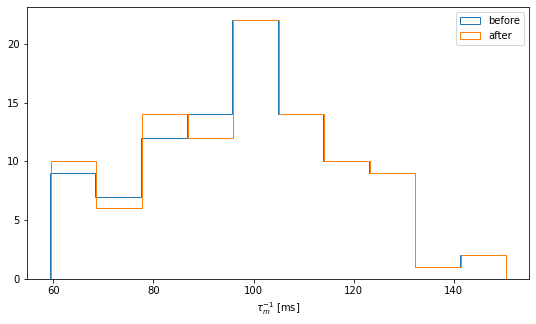

In [233]:
counts, bins = np.histogram(tau_mem_inv_before)
fig, ax = plt.subplots(figsize=(9,5))
ax.hist(bins[:-1], bins, weights=counts, histtype='step', label='before')
counts, bins = np.histogram(tau_mem_inv_after)
ax.hist(bins[:-1], bins, weights=counts, histtype='step', label='after')
ax.set_xlabel('$\\tau_{m}^{-1}$ [ms]')
ax.legend()

Similarly we can plot the distribution of membrane threshold voltages before and after optimisation:

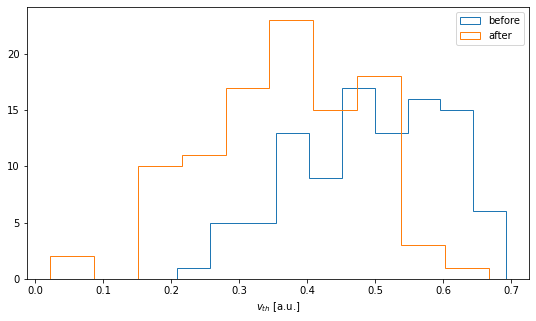

In [234]:
counts, bins = np.histogram(v_th_before)
fig, ax = plt.subplots(figsize=(9,5))
ax.hist(bins[:-1], bins, weights=counts, histtype='step', label='before')
counts, bins = np.histogram(v_th_after)
ax.hist(bins[:-1], bins, weights=counts, histtype='step', label='after')
ax.set_xlabel('$v_{th}$ [a.u.]')
ax.legend()

## Conclusions

This concludes this tutorial, as we have seen incorporating *neuron parameters* into the optimisation in Norse mainly requires knowledge of the PyTorch internals. At the moment that optimisation is also only supported for the surrogate gradient implementation and not while using the discretised adjoint implementation. This is not a fundamental limitation though and support for neuron parameter gradients could be added. 

Several publications have recently explored optimising neuron parameters to both demonstrate that the resulting time constant distributions more closely resembled ones measured in biological cells and advantages in ML applications. As always the challenge to practically demonstrating the advantage of incorporating neuron parameters into the optimisation is doing careful and controlled experiments and choosing the right tasks. While this notebook demonstrates the general technique it does take some shortcuts:

- Optimisation works best if the scale of the values to be optimised is in an appropriate range. This is not the case here for the inverse time constant, which has a value of > 100. A more sophisticated approach would take this into account by for example generating this parameter from an appropriately scaled initial value. 
- Similarly we have chosen a rather naive initialisation of both the threshold and inverse membrane time constant. More careful initialisation would for example involve sampling from a distribution with guaranteed positive samples.
- Finally we haven't demonstrated any benefit of jointly optimising neuron parameters and synaptic weights. 

